In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import os
from evaluation import run_eval

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
all_species = ['grimpus', 'lorpus', 'wumpus', 'zumpus', 'sterpus', 'numpus', 'jompus', 'brimpus', 'yumpus', 'tumpus', 'dumpus', 'vumpus', 'rompus', 'lempus', 'gorpus', 'shumpus', 'impus']
all_attributes = ['fast', 'luminous', 'tall', 'large', 'heavy', 'blonde', 'crazy', 'hungry', 'happy']
all_subjects = ['Grom', 'Wren', 'Trux', 'Jinx', 'Rast']

In [3]:
from generation import few_shot_example

In [4]:
print(few_shot_example(
    n_hops=2, 
    n_shots=5, 
    with_cot=True)[0]
    )

Answer to the following question as shown in the following examples.
Each jompus is not luminous. Each rompus is tall. Lorpuses are tall. Each rompus is a jompus. Each lorpus is heavy. Each lorpus is a vumpus. Each jompus is not heavy. Wren is a rompus. Wren is a vumpus.

Question: Is Wren heavy?
Think step by step.

(1) Wren is a rompus.
(2) Each rompus is a jompus.
(3) Wren is a jompus.
(4) Each jompus is not heavy.
(5) Wren is not heavy.
Answer: No


Each jompus is a impus. Each jompus is large. Each gorpus is not large. Each gorpus is not happy. Each sterpus is not luminous. Jompuses are not luminous. Sterpuses are gorpuses. Rast is a sterpus. Rast is a impus.

Question: Is Rast large?
Think step by step.

(1) Rast is a sterpus.
(2) Sterpuses are gorpuses.
(3) Rast is a gorpus.
(4) Gorpuses are not large.
(5) Rast is not large.
Answer: No


Jompuses are impuses. Zumpuses are large. Each impus is not fast. Zumpuses are hungry. Each jompus is hungry. Each zumpus is a lorpus. Impuses 

## Eval

In [ ]:
model_name = 'meta-llama/Meta-Llama-3-8B-Instruct'
model_label = model_name.split('/')[-1]

if not os.path.exists(f"results/{model_label}"):
    os.makedirs(f"results/{model_label}")

if not os.path.exists(f"eval/{model_label}"):
    os.makedirs(f"eval/{model_label}")

res_df = {
    'N. Shots': [],
    'Prediction Acc.': [],
    'CoT Acc.': [],
    'Agreement': [],
    'With CoT': [] 
}

N = 50

for n_hops in [2, 3]:
    for n_shots in [1, 3, 5, 7, 9]:
        for with_cot in [True, False]: 
            cot_label = 'cot' if with_cot else 'nocot'
            for p in [0.1, 0.3, 0.5, 0.7, 0.9]:
                df, pred_acc, cot_acc, cot_pred_corr = run_eval(model_name, N, n_hops, n_shots, with_cot, p)
                res_df['N. Shots'].append(n_shots)
                res_df['Prediction Acc.'].append(pred_acc)
                res_df['CoT Acc.'].append(cot_acc)
                res_df['Agreement'].append(cot_pred_corr)
                res_df['With CoT'].append(with_cot)

                df.to_csv(f"results/{model_label}/{N}N_{n_hops}hops_{n_shots}shots_{cot_label}_p{p}.csv", index=False)

res_df = pd.DataFrame(res_df)
res_df.to_csv(f"eval/{model_label}/{N}N_{n_hops}hops.csv")

LLM eval

**SYS_PROMPT**

```
You have to evaluate reasoning processes. You will be given a GOLD and a PREDICT processes and you have to determine whether the second is equivalent to the first and answer CORRECT or WRONG. 
Here are some examples: 

GOLD
(1) Jinx is a dumpus.
(2) Dumpuses are grimpuses.
(3) Jinx is a grimpus.
(4) Each grimpus is not hungry.
(5) Jinx is not hungry.

PRED
(1) Jinx is a sterpus.
(2) Each sterpus is a lempus. (We don't need to use this statement for now, but we'll come back to it later.)
(3) Jinx is a dumpus.
(4) Each dumpus is a grimpus.
(5) Jinx is a grimpus.
(6) Each grimpus is not hungry.
(7) Jinx is a grimpus, so Jinx is not hungry.

EVAL: CORRECT


GOLD
(1) Trux is a grimpus.
(2) Grimpuses are rompus.
(3) Trux is a rompus.
(4) Rompuses are not large.
(5) Trux is not large.

PRED
1. Trux is a grimpus.
2. Each grimpus is a rompus.
3. Trux is a rompus.
4. Rompuses are blonde. (Note: This statement is not relevant to the question, but we'll keep it in mind)
5. Each vumpus is large.
6. Vumpuses are gorpus.
7. Trux is a gorpus.
8. Vumpuses are not tall.
9. Trux is a vumpus (from step 7 and step 6).
10. Since Trux is a vumpus, it is large (from step 5).

EVAL: WRONG

Answer only with the final evaluation CORRECT or WRONG.
```

TEST_EXAMPLE

```
GOLD
(1) Wren is a gorpus. 
(2) Each gorpus is a shumpus. 
(3) Wren is a shumpus. 
(4) Shumpuses are heavy. 
(5) Wren is heavy.

PRED
* Wren is a rompus.
* Tumpuses are rompus.
* Wren is a tumpus (from previous question, we know Wren is a tumpus).
* Tumpuses are rompus, so Wren is rompus.
* Wren is a gorpus.
* Each shumpus is heavy.
* Wren is a gorpus, so Wren is a shumpus.
* Each shumpus is heavy, so Wren is heavy.
```

In [5]:
model_name = 'meta-llama/Meta-Llama-3-8B-Instruct'
model_label = model_name.split('/')[-1]

N = 50
n_hops = 3

res_df = pd.read_csv(f"eval/{model_label}/{N}N_{n_hops}hops.csv", index_col=0)

In [6]:
res_df.dropna()

,N. Shots,Prediction Acc.,CoT Acc.,Agreement,With CoT
0,1,0.56,0.44,1.000000,True
1,1,0.68,0.58,1.000000,True
2,1,0.58,0.44,1.000000,True
3,1,0.54,0.34,1.000000,True
4,1,0.62,0.46,1.000000,True
10,3,0.66,0.64,1.000000,True
11,3,0.70,0.68,0.970588,True
12,3,0.58,0.56,1.000000,True
13,3,0.72,0.64,0.968750,True
14,3,0.70,0.66,1.000000,True


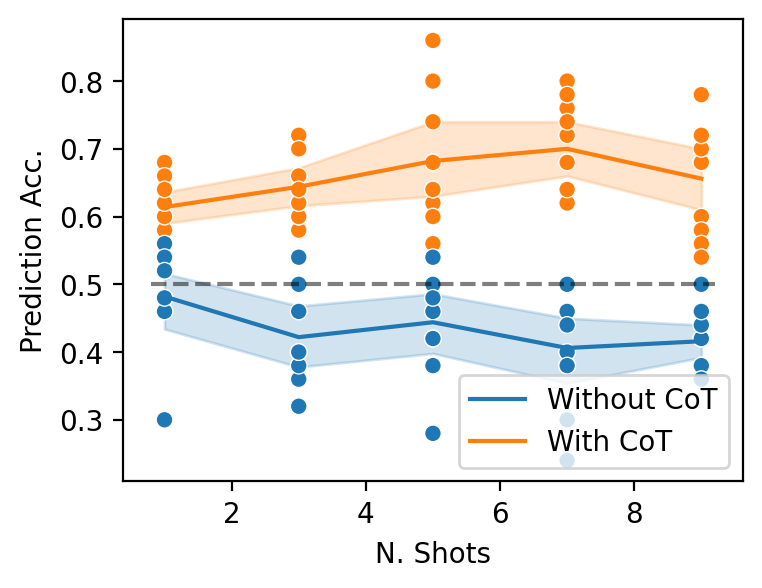

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(4,3), dpi=200)

sns.lineplot(
    data=res_df,
    x='N. Shots', y='Prediction Acc.', hue='With CoT'
)

sns.scatterplot(
    data=res_df,
    x='N. Shots', y='Prediction Acc.', hue='With CoT'
)

plt.hlines(0.5, 0.8, 9.2, 'black', '--', alpha=0.5)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles[:len(handles)//2], labels=['Without CoT', 'With CoT'], loc='lower right')

### Error analysis

In [8]:
model_name = 'meta-llama/Meta-Llama-3-8B-Instruct'
model_label = model_name.split('/')[-1]

N = 50

dfs = []

for n_hops in [1,2,3]:
    for n_shots in [1,3,5,7,9]:
        for cot in ['cot', 'nocot']:
            for p in [0.1,0.3,0.5,0.7,0.9]: 
                dfs.append(pd.read_csv(f'results/{model_label}/{N}N_{n_hops}hops_{n_shots}shots_{cot}_p{p}.csv'))
                dfs[-1]['n_hops'] = n_hops
                dfs[-1]['n_shots'] = n_shots
                dfs[-1]['cot'] = cot
                dfs[-1]['p'] = p

df = pd.concat(dfs, axis=0)

In [9]:
'''
from IPython.display import clear_output

na_mask = df['pred'].isna()
evals = []

for i in tqdm(range(na_mask.sum())):
    row = df[na_mask].iloc[i]
    print(row['prompt'].split('Question:')[-1])
    print(row['answer'])
    eval = input()
    if eval == 'y':
        evals.append('Yes')
    elif eval == 'n':
        evals.append('No')
    else:
        evals.append(np.nan)
    
    # Clear the output
    clear_output(wait=True)
'''

"\nfrom IPython.display import clear_output\n\nna_mask = df['pred'].isna()\nevals = []\n\nfor i in tqdm(range(na_mask.sum())):\n    row = df[na_mask].iloc[i]\n    print(row['prompt'].split('Question:')[-1])\n    print(row['answer'])\n    eval = input()\n    if eval == 'y':\n        evals.append('Yes')\n    elif eval == 'n':\n        evals.append('No')\n    else:\n        evals.append(np.nan)\n    \n    # Clear the output\n    clear_output(wait=True)\n"

In [10]:
df[df['pred'].isna()].groupby(['n_hops', 'n_shots'])['prompt'].count()

n_hops  n_shots
1       5           3
        7           1
        9           1
2       9          24
3       3           2
        7          46
        9          31
Name: prompt, dtype: int64

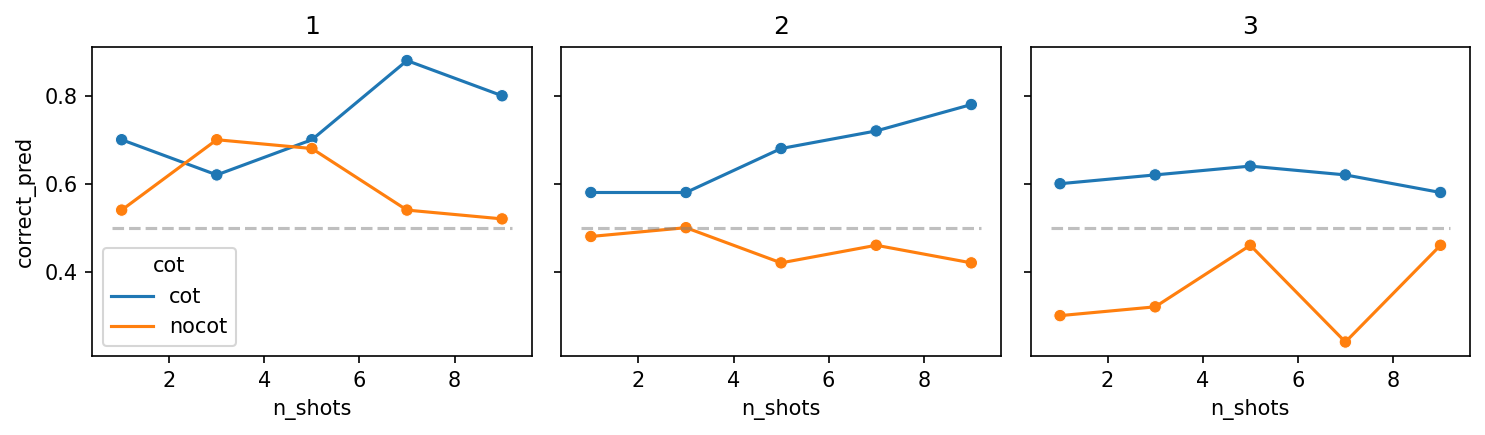

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(10,3), dpi=150, sharey=True)

for i, n_hops in enumerate([1,2,3]):
    plot_df = df[(df['p'] == 0.5) & (df['n_hops'] == n_hops)].groupby(['n_shots', 'cot'])['correct_pred'].mean().reset_index()
    sns.lineplot(plot_df, x='n_shots', y='correct_pred', hue='cot', ax=ax[i], legend=True if i ==  0 else False)
    sns.scatterplot(plot_df, x='n_shots', y='correct_pred', hue='cot', ax=ax[i], legend=False)
    ax[i].hlines(0.5, 0.8, 9.2, color='grey', alpha=.5, linestyle='--')
    ax[i].set_title(n_hops)

plt.tight_layout()
plt.show()

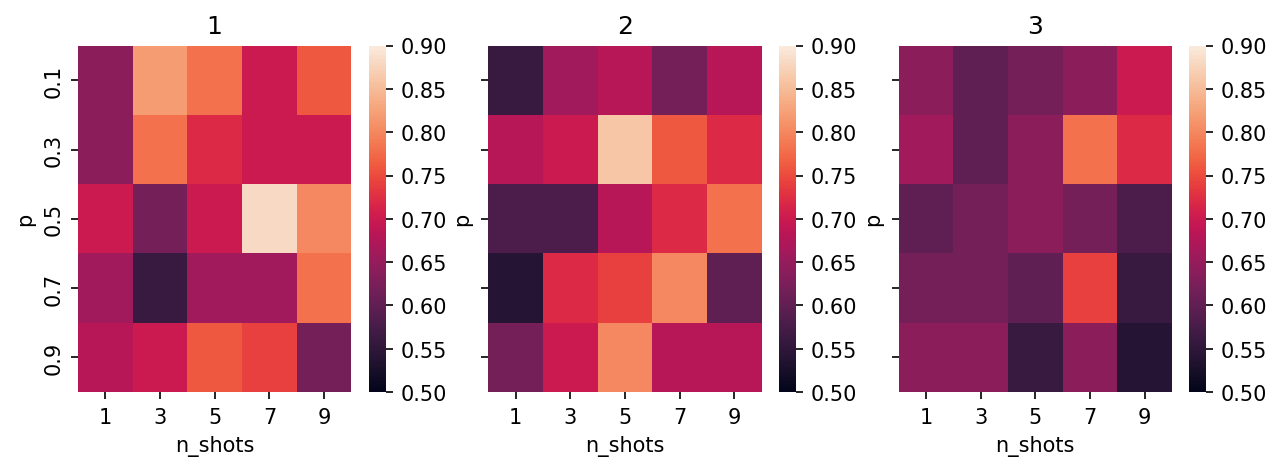

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(10,3), dpi=150, sharey=True)

for i, n_hops in enumerate([1,2,3]):
    plot_df = df[(df['cot'] == 'cot') & (df['n_hops'] == n_hops)].groupby(['n_shots', 'p'])['correct_pred'].mean().reset_index()

    sns.heatmap(plot_df.pivot(index='p', columns='n_shots', values='correct_pred'), vmin=0.5, vmax=.9, ax=ax[i])
    ax[i].set_title(n_hops)

In [13]:
cot_df = df[(df['cot'] == 'cot') & (df['p'] == 0.5)].copy()

In [14]:
import ast

mistakes = []

def check_mistake(row):
    if row['correct_cot'] == 0:
        gold, pred = row[["cot_gold", "cot_pred"]]
        gold = ast.literal_eval(gold)
        pred = ast.literal_eval(pred)
        for j, (gold_step, pred_step) in enumerate(zip(gold, pred)):
            if gold_step != pred_step:
                return j
    else:
        return None

cot_df['mistake'] = cot_df.apply(check_mistake, axis=1)

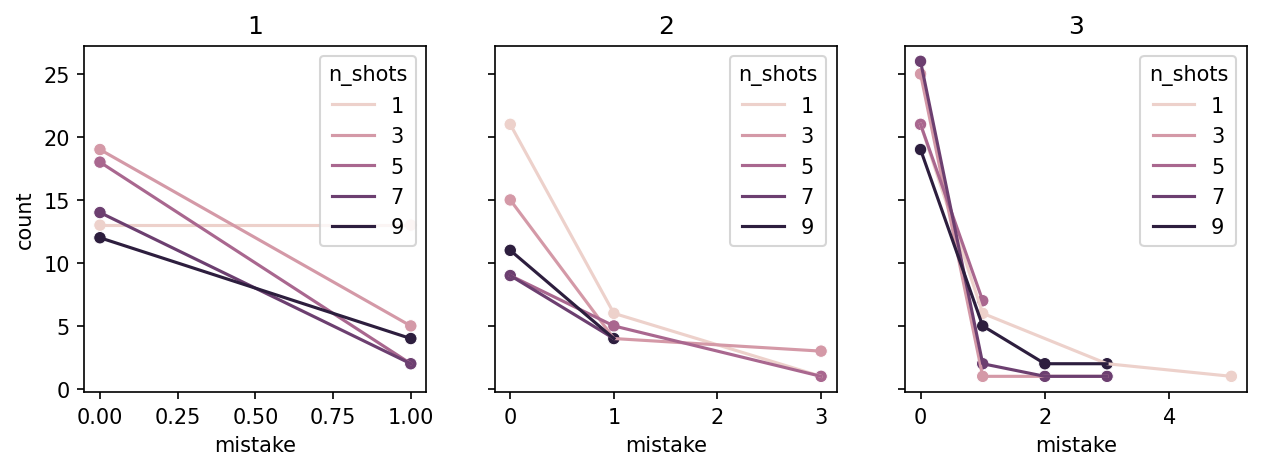

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(10,3), dpi=150, sharey=True)

for i, n_hops in enumerate([1,2,3]):
    sns.lineplot(
        cot_df[cot_df['n_hops'] == n_hops].groupby(['n_hops', 'n_shots'])['mistake'].value_counts().reset_index(),
        x='mistake', y='count', hue='n_shots', ax=ax[i]
    )
    sns.scatterplot(
        cot_df[cot_df['n_hops'] == n_hops].groupby(['n_hops', 'n_shots'])['mistake'].value_counts().reset_index(),
        x='mistake', y='count', hue='n_shots', ax=ax[i], legend=False
    )

    ax[i].set_title(n_hops)

In [20]:
import ast
from evaluation import step_decompose

all_species = ['grimpus', 'lorpus', 'wumpus', 'zumpus', 'sterpus', 'numpus', 'jompus', 'brimpus', 'yumpus', 'tumpus', 'dumpus', 'vumpus', 'rompus', 'lempus', 'gorpus', 'shumpus', 'impus']

def check_err(n_hops, gold, pred, step):

    def count_species(pred):
        k = 0
        for s in all_species:
            if s in pred: k+=1
        return k

    def check_attribute(gold, pred):
        attr = gold.split()[-1][:-1]
        return attr in pred
    
    def checkS2A(step, gold, pred):
        if "not" in gold and "not" not in pred:
            return f"S{step+1}-lose_not"
        if "not" not in gold and "not" in pred:
            return f"S{step+1}-add_not"

        if count_species(pred) > 1:
            return f"S{step+1}-s2a"
        if not check_attribute(gold, pred):
            return f"S{step+1}-miss_a"

    def checkS2S(step, gold, pred):
        if count_species(pred) < 2:
            return f"S{step+1}-a2s"
        if not check_attribute(gold, pred):
            return f"S{step+1}-miss_s"
    
    def checkX2A(step, gold, pred):
        if "not" in gold and "not" not in pred:
            return f"S{step+1}-lose_not"
        if "not" not in gold and "not" in pred:
            return f"S{step+1}-add_not"

        if count_species(pred) > 0:
            return f"S{step+1}-s2a"
        if not check_attribute(gold, pred):
            return f"S{step+1}-miss_a"

    if step == 0: # X -> S
        return "S1-miss"
    elif step == 1: # S -> A (1hop) | S -> S (2-3hops)    
        if n_hops == 1:
            return checkS2A(step, gold, pred)
        elif n_hops > 1:
            return checkS2S(step, gold, pred)
    elif step == 2: # X -> A (1hop) | X -> S (2-3hops)
        if n_hops == 1:
            return checkX2A(step, gold, pred)
        elif n_hops > 1:
            return "S3-miss"
    elif step == 3: # S -> A (2hops) | S -> S (3hops)
        if n_hops == 2:
            return checkS2A(step, gold, pred)
        elif n_hops > 2:
            return checkS2S(step, gold, pred)
    elif step == 4: # X -> A (2hops) | X -> S (3hops)
        if n_hops == 2:
            return checkX2A(step, gold, pred)
        elif n_hops > 2:
            return "S5-miss"
    elif step == 5: # S -> A (3hops)
        if n_hops == 3:
            return checkS2S(step, gold, pred)
    elif step == 6: # X -> A (3hops)
        if n_hops == 3:
            return "S7-miss"

    return "C"
        
def evaluate_(row):
    cot_gold = ast.literal_eval(row['cot_gold'])
    cot_pred = ast.literal_eval(row['cot_pred'])
    n_hops = row['n_hops']
    
    r = ""
    
    for i, (g, p) in enumerate(zip(cot_gold, cot_pred)):
        if any([x != y for x, y in zip(step_decompose(g), step_decompose(p))]):
            err = check_err(n_hops, g, p, i)
        else:
            err = "C"
        
        r += err + "|"

    return r

In [ ]:
api_eval

In [29]:
g, p = cot_df[cot_df['correct_cot'] == False][['cot_gold', 'cot_pred']].iloc[1]
g = ast.literal_eval(g)
p = ast.literal_eval(p)

for i, step in enumerate(g):
    print(f"({i+1}) {step}")

print('\n\n')
for i, step in enumerate(p):
    print(f"({i+1}) {step}")

(1) Grom is a shumpus.
(2) Shumpuses are not crazy.
(3) Grom is not crazy.



(1) Grom is a shumpus.
(2) Each shumpus is luminous. (This doesn't tell us anything about Grom being crazy or not.)
(3) Wumpuses are gorpuses. (This tells us that wumpuses are also gorpus, but it doesn't affect Grom's craziness.)
(4) Each gorpus is not fast. (This doesn't tell us anything about Grom's craziness either.)
(5) Each wumpus is crazy. (This tells us that all wumpuses are crazy, but it doesn't directly affect Grom's craziness.)
(6) Grom is a gorpus. (This tells us that Grom is also a gorpus, but we already knew that from step 3.)


In [276]:
dfs = []
stages = [f"S{i}" for i in range(n_hops * 2 + 1)]

for n_shots in ["1shots", "3shots", "5shots", "7shots", "9shots"]:
    pd.read_csv(f'results/{model_label}/{N}N_{n_hops}hops_{n_shots}_cot.csv')
    df['correct_pred'] = df['label'] == df['pred']
    df['correct_cot'] = df.apply(check_cot, axis=1)

    df['errors'] = df.apply(evaluate_, axis=1)

    df['errors'] = df['errors'].apply(lambda x: x[:-1])
    df[stages] = df['errors'].str.split('|', expand=True)
    for stage in stages:
        df[stage] = df[stage].apply(lambda x: f'{stage}-C' if x == 'C' else x)
    dfs.append(df[stages + ['correct_pred']])

In [278]:
import pandas as pd
import plotly.graph_objects as go

df = dfs[4]

# Prepare the data for the Sankey diagram
all_labels = list(pd.unique(df[stages + ['correct_pred']].values.ravel('K')))
label_dict = {label: i for i, label in enumerate(all_labels)}

sources = []
targets = []
values = []

# Count the flows between stages
for i in range(len(stages)):
    stage = stages[i]
    next_stage = stages + ['correct_pred']
    next_stage = next_stage[i + 1]
    stage_counts = df.groupby([stage, next_stage]).size().reset_index(name='count')
    
    for _, row in stage_counts.iterrows():
        sources.append(label_dict[row[stage]])
        targets.append(label_dict[row[next_stage]])
        values.append(row['count'])

# Define node and link data for Sankey diagram
node = dict(
    pad = 15,
    thickness = 20,
    line = dict(color = "black", width = 0.5),
    label = all_labels,
)

link = dict(
    source = sources,
    target = targets,
    value = values
)

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(node=node, link=link)])
fig.update_layout(title_text="Observation Flow into Variables", font_size=10, width=800)
fig.show()

## Faithfulness

In [ ]:
import os
model_name = 'meta-llama/Meta-Llama-3-8B-Instruct'
model_label = model_name.split('/')[-1]

if not os.path.exists(f"results/{model_label}"):
    os.makedirs(f"results/{model_label}")

if not os.path.exists(f"eval/{model_label}"):
    os.makedirs(f"eval/{model_label}")

res_df = {
    'N. Shots': [],
    'Prediction Acc.': [],
    'CoT Acc.': [],
    'Agreement': [],
    'With CoT': [] 
}

N = 10
n_hops = 2

for n_shots in [3,5,7,9]:
    for with_cot in [True, False]: 
        for p in [0.05, 0.25, 0.5, 0.75, 0.95]:
            df, pred_acc, cot_acc, cot_pred_corr = run_eval(N, n_hops, n_shots, with_cot)
            res_df['N. Shots'].append(n_shots)
            res_df['Prediction Acc.'].append(pred_acc)
            res_df['CoT Acc.'].append(cot_acc)
            res_df['Agreement'].append(cot_pred_corr)
            res_df['With CoT'].append(with_cot)

res_df = pd.DataFrame(res_df)
res_df.to_csv(f"eval/{model_label}/{N}N_{n_hops}hops.csv")

100%|██████████| 30/30 [00:47<00:00,  1.59s/it]


## Artihmetic Task

In [1]:
from transformers import AutoTokenizer

model_name = 'meta-llama/Meta-Llama-3-8B-Instruct'
tokenizer = AutoTokenizer.from_pretrained(model_name)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [2]:
import operator
import numpy as np

ops = {'+': operator.add, '-': operator.sub, '*': operator.mul, '/': operator.truediv}

def gen_expression(with_cot=True):
    result = 1000
    while result < 0 or result > 999:
        a, b, c, d, e = np.random.choice(range(1, 99), 5)
        op1, op2, op3, op4 = np.random.choice(['+', '-', '*'], p=[.4, .4, .2], size=4)
        result = ops[op3](ops[op2](ops[op1](a, b), c), ops[op4](d, e))
        # [(a op1 b) op2 c] op3 (d op4 e)
        a_b = ops[op1](a, b)
        a_b_c = ops[op2](a_b, c)
        d_e = ops[op4](d, e)
        if a_b < 0 or a_b_c < 0 or d_e < 0: result = -1

    if with_cot:
        solving = f"Answer: x=[{a_b}{op2}{c}] {op3}{d_e} = {a_b_c}{op3}{d_e} = {result}"
    else:
        solving = f"Answer: x={result}"
    
    return f"Expression: x= [ ({a}{op1}{b}) {op2}{c}] {op3} ({d}{op4}{e})", solving

def few_shot_example(n_shots, with_cot):
    prompt = "Solve the following expression as shown in the examples.\n\n"
    
    for i in range(n_shots):
        task, solving = gen_expression(with_cot)
        prompt += task + "\n" + solving + "\n\n"
    
    task, solving = gen_expression()
    prompt += task + "\nAnswer:"
    return prompt, solving

In [3]:
print(few_shot_example(1, True)[0])

Solve the following expression as shown in the examples.

Expression: x= [ (33+92) +84] + (45+84)
Answer: x=[125+84] +129 = 209+129 = 338

Expression: x= [ (43+53) -6] + (19+12)
Answer:


In [4]:
#example, solution = few_shot_example(1, True)
#tokens = tokenizer(example, return_tensors='pt')
#str_tokens = tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])
#str_tokens

In [5]:
from utils import replicate_generate

example, solving = few_shot_example(1, True)
out = replicate_generate(example, 'meta/meta-llama-3-8b', max_new_tokens=18)

In [6]:
answer = int(out.split('\n')[0].split('=')[-1].strip())
solution = int(solving.split('=')[-1].strip())

In [7]:
print(out)
answer

 x=[35-19] -1 = 16-1 = 15

Expression


15

In [ ]:
from tqdm.auto import tqdm
import pandas as pd

result_df = {
    'prompt': [],
    'answer': [],
    'solution': [],
    'solving': [],
    'n_shots': [],
    'cot': []
}
for n_shots in [1,3,5]:
    for cot in [True, False]:
        for i in tqdm(range(50)):
            example, solving = few_shot_example(n_shots, cot)
            
            out = replicate_generate(example, 'meta/meta-llama-3-8b', max_new_tokens=18)
            try:
                answer = int(out.split('\n')[0].split('=')[-1].strip())
            except:
                answer = np.nan
            solution = int(solving.split('=')[-1].strip())
            
            result_df['prompt'].append(example)
            result_df['answer'].append(answer)
            result_df['solution'].append(solution)
            result_df['solving'].append(solving)
            result_df['n_shots'].append(n_shots)
            result_df['cot'].append(cot)

result_df = pd.DataFrame(result_df)

In [11]:
result_df

,prompt,answer,solution,solving,n_shots,cot
0,Solve the following expression as shown in the...,7.0,7,Answer: x=[117-75] -35 = 42-35 = 7,1,True
1,Solve the following expression as shown in the...,91.0,91,Answer: x=[27+31] +33 = 58+33 = 91,1,True
2,Solve the following expression as shown in the...,222.0,222,Answer: x=[87+90] +45 = 177+45 = 222,1,True
3,Solve the following expression as shown in the...,41.0,41,Answer: x=[164-8] -115 = 156-115 = 41,1,True
4,Solve the following expression as shown in the...,176.0,176,Answer: x=[12+34] +130 = 46+130 = 176,1,True
...,...,...,...,...,...,...
295,Solve the following expression as shown in the...,135.0,95,Answer: x=[84+76] -65 = 160-65 = 95,5,False
296,Solve the following expression as shown in the...,21.0,30,Answer: x=[29+1] +0 = 30+0 = 30,5,False
297,Solve the following expression as shown in the...,183.0,220,Answer: x=[65-26] +181 = 39+181 = 220,5,False
298,Solve the following expression as shown in the...,63.0,7,Answer: x=[10+30] -33 = 40-33 = 7,5,False


In [12]:
result_df['correct'] = result_df['answer'] == result_df['solution']

In [104]:
result_df.groupby(['n_shots', 'cot'])['correct'].mean()

n_shots  cot  
1        False    0.04
         True     0.96
3        False    0.02
         True     1.00
5        False    0.02
         True     1.00
Name: correct, dtype: float64

In [106]:
result_df.to_csv(f'results/{model_name.split('/')[-1]}/arithmetics.csv', index=False)

### Tensor shape manipulation

In [64]:
import operator
import numpy as np

ops = {'+': operator.add, '-': operator.sub, '*': operator.mul, '/': operator.truediv}

def gen_example(with_cot=True):
    # The task implies retriving the final shape of the tensor after the operations
    # Initial shape: [a, b, c]
    # Operations: select, matmul, cat
    a, b, c, d, e = np.random.choice(range(1, 10), 5)
    select_id = np.random.choice(range(3))
    select_str = f"{'0' if select_id == 0 else ':'}, {'0' if select_id == 1 else ':'}, {'0' if select_id == 2 else ':'}"
    s_shape = [b if select_id == 0 else a] + [b if select_id == 2 else c]
    m_shape = [c if select_id != 2 else b] + [d] 
    f_shape = [a if select_id != 0 else b] + [d]
    
    cat_dim = np.random.choice([0, 1])
    cat_shape = [f_shape[0] if cat_dim == 1 else e] + [f_shape[1] if cat_dim == 0 else e]
    correct_shape = [f_shape[0] + cat_shape[0] if cat_dim == 0 else f_shape[0]] + [f_shape[1] + cat_shape[1] if cat_dim == 1 else f_shape[1]]

    if with_cot:
        solving = f"Answer:\n(1) x[{select_str}] has shape [{s_shape[0]} {s_shape[1]}]\n(2) x[{select_str}]@A has shape [{f_shape[0]} {f_shape[1]}]\n(3) cat(x[{select_str}]@A, z, dim={cat_dim}) has shape [{correct_shape[0]} {correct_shape[1]}]"
    else:
        solving = f"Answer: y has shape [{correct_shape[0]} {correct_shape[1]}]"
    
    return f"Initial shapes:\nx: [{a} {b} {c}]\nA: [{m_shape[0]} {m_shape[1]}]\nz: [{cat_shape[0]} {cat_shape[1]}]\nOperations: y=cat(x[{select_str}]@A, z, dim={cat_dim})", solving

def few_shot_example(n_shots, with_cot):
    prompt = "Find the shape of the y tensor. Answer as shown in the examples.\n\n"
    
    for i in range(n_shots):
        task, solving = gen_example(with_cot)
        prompt += task + "\n" + solving + "\n\n"
    
    task, solving = gen_example()
    prompt += task + "\nAnswer:"
    return prompt, solving

In [65]:
print(few_shot_example(2, False)[0])

Find the shape of the y tensor. Answer as shown in the examples.

Initial shapes:
x: [2 9 1]
A: [1 7]
z: [9 1]
Operations: y=cat(x[0, :, :]@A, z, dim=1)
Answer: y has shape [9 8]

Initial shapes:
x: [4 8 9]
A: [9 8]
z: [7 8]
Operations: y=cat(x[0, :, :]@A, z, dim=0)
Answer: y has shape [15 8]

Initial shapes:
x: [3 6 2]
A: [6 6]
z: [3 2]
Operations: y=cat(x[:, :, 0]@A, z, dim=1)
Answer:


In [ ]:
#example, solution = few_shot_example(1, True)
#tokens = tokenizer(example, return_tensors='pt')
#str_tokens = tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])
#str_tokens

In [127]:
from utils import replicate_generate

example, solving = few_shot_example(3, True)
out = replicate_generate(example, 'meta/meta-llama-3-8b', max_new_tokens=64)

In [128]:
print(example)

Find the shape of the y tensor. Answer as shown in the examples.

Initial shapes:
x: [5 9 8]
A: [8 6]
z: [5 2]
Operations: y=cat(x[:, 0, :]@A, z, dim=1)
Answer:
(1) x[:, 0, :] has shape [5 8]
(2) x[:, 0, :]@A has shape [5 6]
(3) cat(x[:, 0, :]@A, z, dim=1) has shape [5 8]

Initial shapes:
x: [2 9 1]
A: [1 6]
z: [9 6]
Operations: y=cat(x[0, :, :]@A, z, dim=1)
Answer:
(1) x[0, :, :] has shape [9 1]
(2) x[0, :, :]@A has shape [9 6]
(3) cat(x[0, :, :]@A, z, dim=1) has shape [9 12]

Initial shapes:
x: [5 7 3]
A: [3 7]
z: [5 7]
Operations: y=cat(x[0, :, :]@A, z, dim=0)
Answer:
(1) x[0, :, :] has shape [7 3]
(2) x[0, :, :]@A has shape [7 7]
(3) cat(x[0, :, :]@A, z, dim=0) has shape [12 7]

Initial shapes:
x: [3 7 6]
A: [7 3]
z: [5 3]
Operations: y=cat(x[:, :, 0]@A, z, dim=0)
Answer:


In [129]:
print(out)
print(solving)

 
(1) x[:, :, 0] has shape [3 7]
(2) x[:, :, 0]@A has shape [3 3]
(3) cat(x[:, :, 0]@A, z, dim=0) has shape [8 3]

Final Answer:
Answer:
(1) x[:, :, 0] has shape [3 7]
(2) x[:, :, 0]@A has shape [3 3]
(3) cat(x[:, :, 0]@A, z, dim=0) has shape [8 3]


In [130]:
answer = out.split('\n\n')[0].split('shape ')[-1].strip()
solution = solving.split('shape ')[-1]
print(answer, solution)

[8 3] [8 3]


In [131]:
from tqdm.auto import tqdm
import pandas as pd

result_df = {
    'prompt': [],
    'answer': [],
    'solution': [],
    'solving': [],
    'n_shots': [],
    'cot': []
}
for n_shots in [1,3,5]:
    for cot in [True, False]:
        for i in tqdm(range(50)):
            example, solving = few_shot_example(n_shots, cot)
            
            out = replicate_generate(example, 'meta/meta-llama-3-8b', max_new_tokens=64)
            try:
                answer = out.split('\n\n')[0].split('shape ')[-1].strip()
            except:
                answer = np.nan
            solution = solving.split('shape ')[-1]
            
            result_df['prompt'].append(example)
            result_df['answer'].append(answer)
            result_df['solution'].append(solution)
            result_df['solving'].append(solving)
            result_df['n_shots'].append(n_shots)
            result_df['cot'].append(cot)

result_df = pd.DataFrame(result_df)

100%|██████████| 50/50 [00:55<00:00,  1.10s/it]


In [135]:
result_df

,prompt,answer,solution,solving,n_shots,cot,correct
0,Find the shape of the y tensor. Answer as show...,[8 12],[8 14],"Answer:\n(1) x[:, :, 0] has shape [8 7]\n(2) x...",1,True,False
1,Find the shape of the y tensor. Answer as show...,[8 14],[8 14],"Answer:\n(1) x[:, 0, :] has shape [8 1]\n(2) x...",1,True,True
2,Find the shape of the y tensor. Answer as show...,[5 12],[5 12],"Answer:\n(1) x[0, :, :] has shape [5 9]\n(2) x...",1,True,True
3,Find the shape of the y tensor. Answer as show...,[5 4],[5 4],"Answer:\n(1) x[0, :, :] has shape [4 7]\n(2) x...",1,True,True
4,Find the shape of the y tensor. Answer as show...,[7 8],[7 8],"Answer:\n(1) x[:, :, 0] has shape [7 2]\n(2) x...",1,True,True
...,...,...,...,...,...,...,...
295,Find the shape of the y tensor. Answer as show...,[3 5],[3 5],"Answer:\n(1) x[:, 0, :] has shape [3 2]\n(2) x...",5,False,True
296,Find the shape of the y tensor. Answer as show...,[10 1],[9 1],"Answer:\n(1) x[0, :, :] has shape [6 7]\n(2) x...",5,False,False
297,Find the shape of the y tensor. Answer as show...,[2 16],[2 8],"Answer:\n(1) x[0, :, :] has shape [2 9]\n(2) x...",5,False,False
298,Find the shape of the y tensor. Answer as show...,[9 5],[4 5],"Answer:\n(1) x[:, 0, :] has shape [2 7]\n(2) x...",5,False,False


In [134]:
result_df['correct'] = result_df['answer'] == result_df['solution']

In [136]:
result_df.groupby(['n_shots', 'cot'])['correct'].mean()

n_shots  cot  
1        False    0.26
         True     0.54
3        False    0.44
         True     0.72
5        False    0.48
         True     0.76
Name: correct, dtype: float64

In [137]:
result_df.to_csv(f'results/{model_name.split('/')[-1]}/tensors.csv', index=False)